In [24]:
import torch
import matplotlib.pyplot as plt

from m2_utilities.load_data import load_trajectories
from m2_utilities.qwen import load_qwen
from m2_utilities.metrics import forecast_points, compute_mae

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading the Model and Data

In [25]:
# Model
model, tokenizer = load_qwen()

In [26]:
# Loading trajectories
trajectories = load_trajectories("data/lotka_volterra_data.h5")

sample = trajectories[:1, :55]

### Forecasting

In [27]:
N_FORECAST = 25
forecast = forecast_points(model, sample, N_FORECAST, decimals=3)

In [28]:
print(forecast.shape)
print(sample.shape)
mae = compute_mae(forecast, trajectories[:1, 55:80, :])
print(mae)

torch.Size([1, 25, 2])
torch.Size([1, 55, 2])
0.5097954869270325


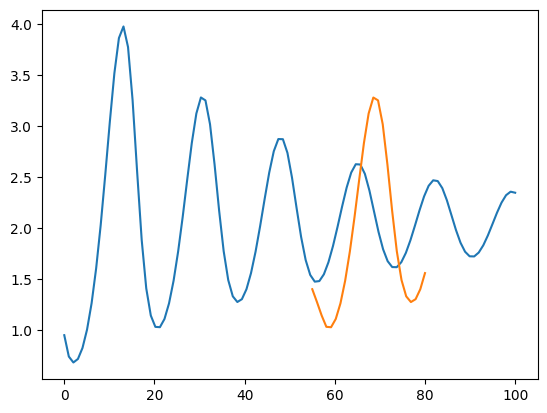

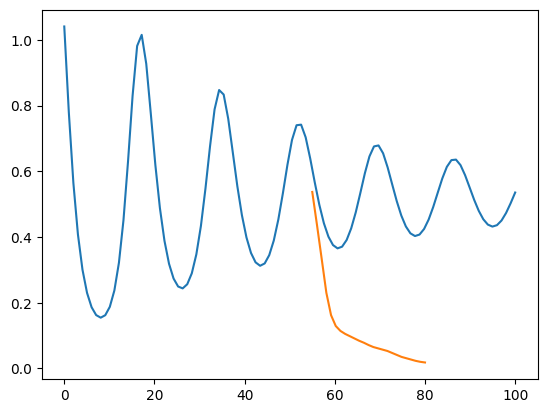

In [29]:
plt.plot(torch.linspace(0, 100, 100), trajectories[0, :, 0])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), forecast[0, :, 0])
plt.show()

plt.plot(torch.linspace(0, 100, 100), trajectories[0, :, 1])
plt.plot(torch.linspace(55, 55 + N_FORECAST, N_FORECAST), forecast[0, :, 1])
plt.show()